Mô hình deep - 5 hidden layers

Class weights: {0: np.float64(2.546850598646538), 1: np.float64(0.6221388606307223)}
Epoch 1/40
520/520 - 14s - 26ms/step - auc: 0.7304 - loss: 0.7123 - precision: 0.8947 - recall: 0.6381 - val_auc: 0.8090 - val_loss: 0.6755 - val_precision: 0.9292 - val_recall: 0.6800 - learning_rate: 5.0000e-04
Epoch 2/40
520/520 - 9s - 18ms/step - auc: 0.8006 - loss: 0.6363 - precision: 0.9205 - recall: 0.6891 - val_auc: 0.8513 - val_loss: 0.5951 - val_precision: 0.9445 - val_recall: 0.7238 - learning_rate: 5.0000e-04
Epoch 3/40
520/520 - 10s - 19ms/step - auc: 0.8427 - loss: 0.5822 - precision: 0.9378 - recall: 0.7204 - val_auc: 0.8740 - val_loss: 0.5390 - val_precision: 0.9450 - val_recall: 0.7600 - learning_rate: 5.0000e-04
Epoch 4/40
520/520 - 7s - 13ms/step - auc: 0.8680 - loss: 0.5426 - precision: 0.9491 - recall: 0.7362 - val_auc: 0.8954 - val_loss: 0.4847 - val_precision: 0.9466 - val_recall: 0.7992 - learning_rate: 5.0000e-04
Epoch 5/40
520/520 - 6s - 12ms/step - auc: 0.8944 - loss: 0.4991 

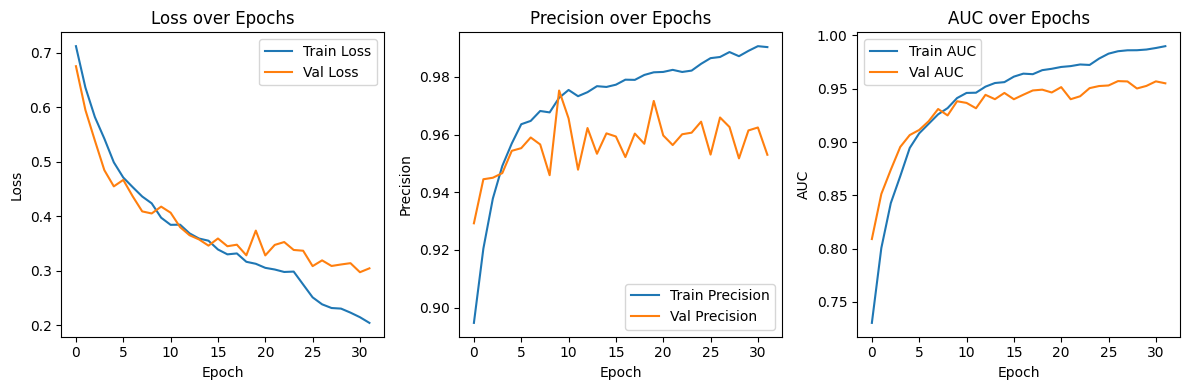

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.86      0.78       959
         1.0       0.96      0.92      0.94      3934

    accuracy                           0.91      4893
   macro avg       0.84      0.89      0.86      4893
weighted avg       0.92      0.91      0.91      4893

Precision (sklearn): 0.9636752136752137
Recall (sklearn): 0.9171326893746823
F1 Score (sklearn): 0.9398280802292264
AUC (sklearn): 0.952198369022129

Confusion Matrix:
 [[ 823  136]
 [ 326 3608]]


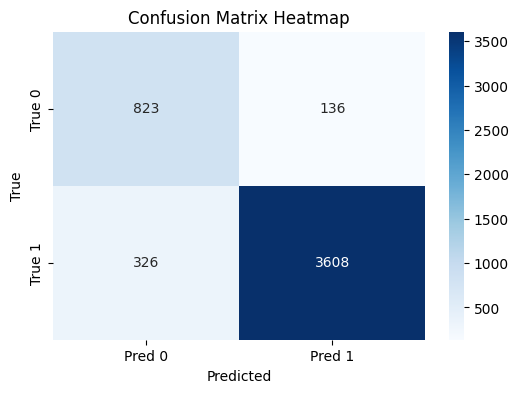

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load dữ liệu
df = pd.read_csv("/content/final_features_full.csv")
X = df.drop("label", axis=1)
y = df["label"]

# Chuẩn hóa
columns_to_scale = [
    'raised_amount_usd', 'funding_total_usd', 'raised_amount_m', 'raised_amount_b',
    'raised_amount_k', 'num_investors', 'success_rate', 'failure_rate', 'success_amount',
    'fail_amount', 'total_amount', 'avg_funding_per_investor', 'num_of_success_companies',
    'num_of_failed_companies', 'funded_at_year', 'funded_at_month', 'funded_at_day',
    'funding_total_m', 'funding_total_b', 'funding_total_k', 'company_age', 'funding_duration_days',
    'avg_funding_duration_per_round', 'funding_duration_months', 'funding_duration_years',
    'founded_at_year', 'founded_at_month', 'founded_at_day', 'first_funding_year',
    'first_funding_month', 'first_funding_day', 'last_funding_year', 'last_funding_month',
    'last_funding_day', 'top_past_sector', 'top_current_sector', 'top_future_sector', 'funding_frequency'
]
scaler = StandardScaler()
X_scaled_part = pd.DataFrame(scaler.fit_transform(X[columns_to_scale]), columns=columns_to_scale)
X_remaining = X.drop(columns=columns_to_scale)
X_final = pd.concat([X_scaled_part.reset_index(drop=True), X_remaining.reset_index(drop=True)], axis=1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Tính class weights để cân bằng dữ liệu
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# Xây dựng mô hình
input_dim = X_train.shape[1]
model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Callbacks
earlystop_cb = callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max')
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, min_lr=1e-6, mode='max')
checkpoint_cb = callbacks.ModelCheckpoint('best_deep_model.keras', save_best_only=True, monitor='val_auc', mode='max')
# Train
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.15,
    class_weight=class_weights_dict,
    callbacks=[earlystop_cb, reduce_lr_cb, checkpoint_cb],
    verbose=2
)

# Vẽ biểu đồ các chỉ số huấn luyện và validation
history_dict = history.history

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Precision
plt.subplot(1, 3, 2)
plt.plot(history_dict['precision'], label='Train Precision')
plt.plot(history_dict['val_precision'], label='Val Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(history_dict['auc'], label='Train AUC')
plt.plot(history_dict['val_auc'], label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Đánh giá
model.load_weights('best_deep_model.keras')
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# In các chỉ số đánh giá
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Precision (sklearn):", precision_score(y_test, y_pred))
print("Recall (sklearn):", recall_score(y_test, y_pred))
print("F1 Score (sklearn):", f1_score(y_test, y_pred))
print("AUC (sklearn):", roc_auc_score(y_test, y_pred_prob))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# Vẽ heatmap confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

Mô hình deep - 6 hidden layers

Class weights: {0: np.float64(2.546850598646538), 1: np.float64(0.6221388606307223)}
Epoch 1/50
520/520 - 17s - 32ms/step - auc: 0.7203 - loss: 0.7861 - precision: 0.8942 - recall: 0.6157 - val_auc: 0.8012 - val_loss: 0.6832 - val_precision: 0.9076 - val_recall: 0.7697 - learning_rate: 5.0000e-04
Epoch 2/50
520/520 - 10s - 19ms/step - auc: 0.7818 - loss: 0.7109 - precision: 0.9155 - recall: 0.6781 - val_auc: 0.8327 - val_loss: 0.7115 - val_precision: 0.9548 - val_recall: 0.6408 - learning_rate: 5.0000e-04
Epoch 3/50
520/520 - 9s - 16ms/step - auc: 0.8147 - loss: 0.6707 - precision: 0.9295 - recall: 0.6877 - val_auc: 0.8440 - val_loss: 0.6330 - val_precision: 0.9328 - val_recall: 0.7545 - learning_rate: 5.0000e-04
Epoch 4/50
520/520 - 9s - 17ms/step - auc: 0.8491 - loss: 0.6213 - precision: 0.9442 - recall: 0.7156 - val_auc: 0.8867 - val_loss: 0.6042 - val_precision: 0.9591 - val_recall: 0.7503 - learning_rate: 5.0000e-04
Epoch 5/50
520/520 - 11s - 22ms/step - auc: 0.8731 - loss: 0.5871

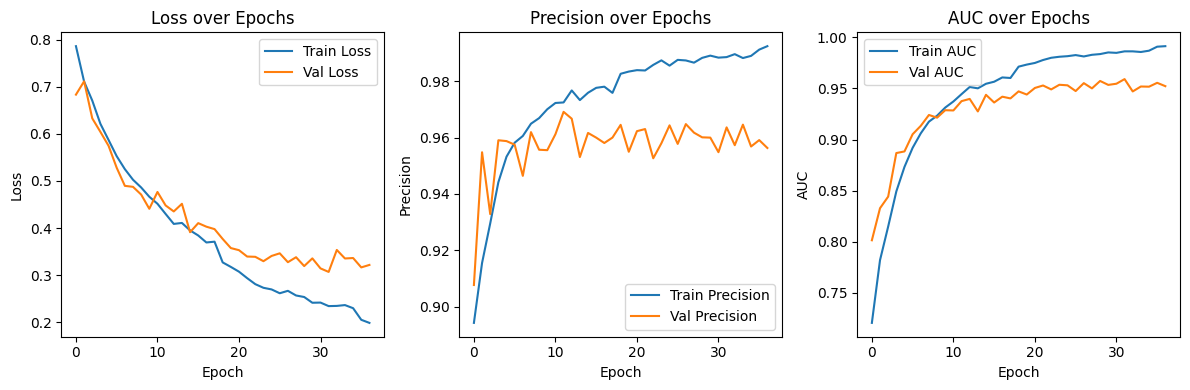

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.85      0.78       959
         1.0       0.96      0.92      0.94      3934

    accuracy                           0.91      4893
   macro avg       0.84      0.89      0.86      4893
weighted avg       0.92      0.91      0.91      4893

Precision (sklearn): 0.9620286776420606
Recall (sklearn): 0.9209456024402644
F1 Score (sklearn): 0.941038961038961
AUC (sklearn): 0.9537815827684426

Confusion Matrix:
 [[ 816  143]
 [ 311 3623]]


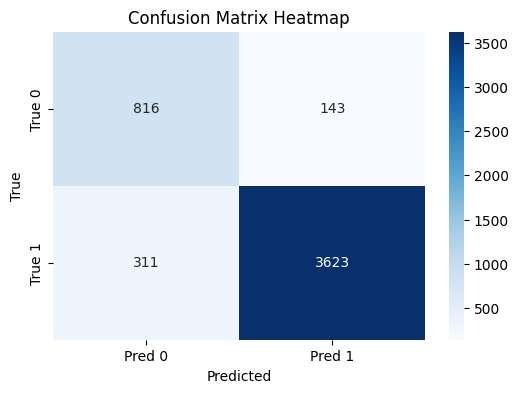

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load dữ liệu
df = pd.read_csv("/content/final_features_full.csv")
X = df.drop("label", axis=1)
y = df["label"]

# Chuẩn hóa
columns_to_scale = [
    'raised_amount_usd', 'funding_total_usd', 'raised_amount_m', 'raised_amount_b',
    'raised_amount_k', 'num_investors', 'success_rate', 'failure_rate', 'success_amount',
    'fail_amount', 'total_amount', 'avg_funding_per_investor', 'num_of_success_companies',
    'num_of_failed_companies', 'funded_at_year', 'funded_at_month', 'funded_at_day',
    'funding_total_m', 'funding_total_b', 'funding_total_k', 'company_age', 'funding_duration_days',
    'avg_funding_duration_per_round', 'funding_duration_months', 'funding_duration_years',
    'founded_at_year', 'founded_at_month', 'founded_at_day', 'first_funding_year',
    'first_funding_month', 'first_funding_day', 'last_funding_year', 'last_funding_month',
    'last_funding_day', 'top_past_sector', 'top_current_sector', 'top_future_sector', 'funding_frequency'
]
scaler = StandardScaler()
X_scaled_part = pd.DataFrame(scaler.fit_transform(X[columns_to_scale]), columns=columns_to_scale)
X_remaining = X.drop(columns=columns_to_scale)
X_final = pd.concat([X_scaled_part.reset_index(drop=True), X_remaining.reset_index(drop=True)], axis=1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Tính class weights để cân bằng dữ liệu
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# Xây dựng mô hình
input_dim = X_train.shape[1]
model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Callbacks
earlystop_cb = callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max')
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, min_lr=1e-6, mode='max')
checkpoint_cb = callbacks.ModelCheckpoint('best_deep_model.keras', save_best_only=True, monitor='val_auc', mode='max')
# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.15,
    class_weight=class_weights_dict,
    callbacks=[earlystop_cb, reduce_lr_cb, checkpoint_cb],
    verbose=2
)

# Vẽ biểu đồ các chỉ số huấn luyện và validation
history_dict = history.history

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Precision
plt.subplot(1, 3, 2)
plt.plot(history_dict['precision'], label='Train Precision')
plt.plot(history_dict['val_precision'], label='Val Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(history_dict['auc'], label='Train AUC')
plt.plot(history_dict['val_auc'], label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Đánh giá
model.load_weights('best_deep_model.keras')
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# In các chỉ số đánh giá
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Precision (sklearn):", precision_score(y_test, y_pred))
print("Recall (sklearn):", recall_score(y_test, y_pred))
print("F1 Score (sklearn):", f1_score(y_test, y_pred))
print("AUC (sklearn):", roc_auc_score(y_test, y_pred_prob))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# Vẽ heatmap confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()